# Healthcare Provider Fraud Detection  
## Notebook 1 – Data Understanding & Feature Engineering

This notebook explores the dataset, validates relationships, and builds provider-level features.


Loaded shapes:
bene: (138556, 25)
inp : (40474, 30)
out : (517737, 27)
prov: (5410, 2)
Providers (labels): 5410
Beneficiaries: 138556
Inpatient claims: 40474
Outpatient claims: 517737

Missing in Beneficiary:
 DOD                      98.97%
BeneID                     0.0%
DOB                        0.0%
Gender                     0.0%
Race                       0.0%
RenalDiseaseIndicator      0.0%
State                      0.0%
County                     0.0%
NoOfMonths_PartACov        0.0%
NoOfMonths_PartBCov        0.0%
dtype: object

Missing in Inpatient:
 ClmProcedureCode_6     100.0%
ClmProcedureCode_5     99.98%
ClmProcedureCode_4     99.71%
ClmProcedureCode_3     97.62%
ClmDiagnosisCode_10     90.3%
OtherPhysician         88.41%
ClmProcedureCode_2     86.52%
ClmProcedureCode_1     42.81%
OperatingPhysician     41.12%
ClmDiagnosisCode_9     33.35%
dtype: object

Missing in Outpatient:
 ClmProcedureCode_5     100.0%
ClmProcedureCode_6     100.0%
ClmProcedureCode_4     100.0%
Clm

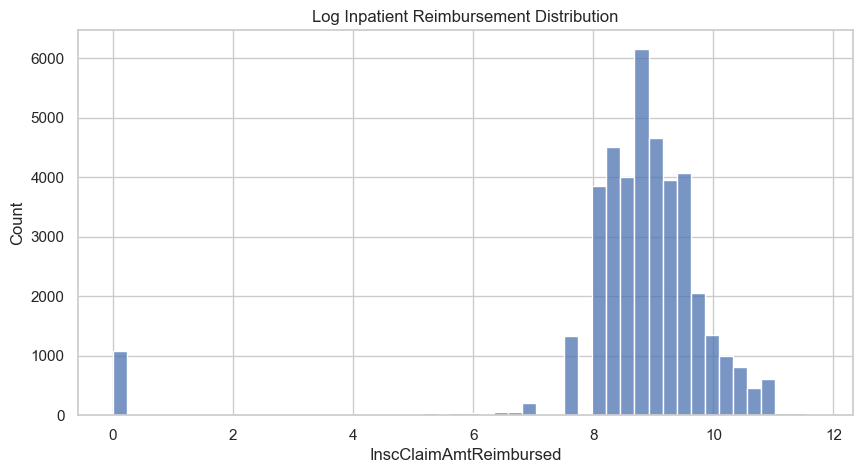

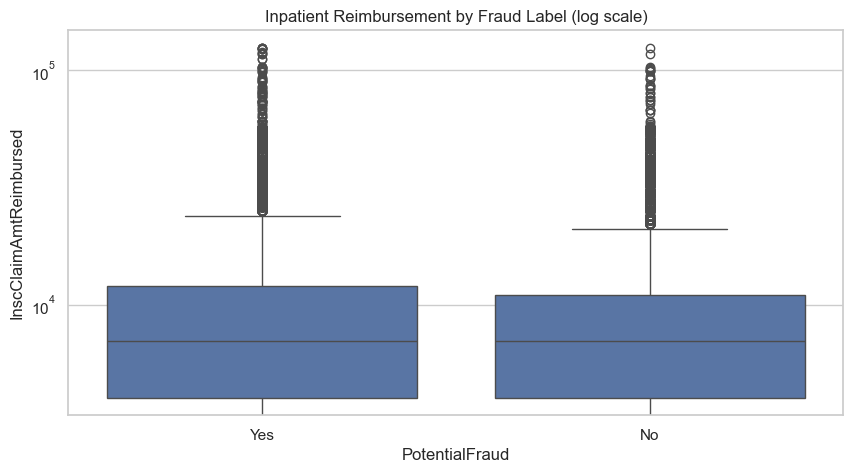

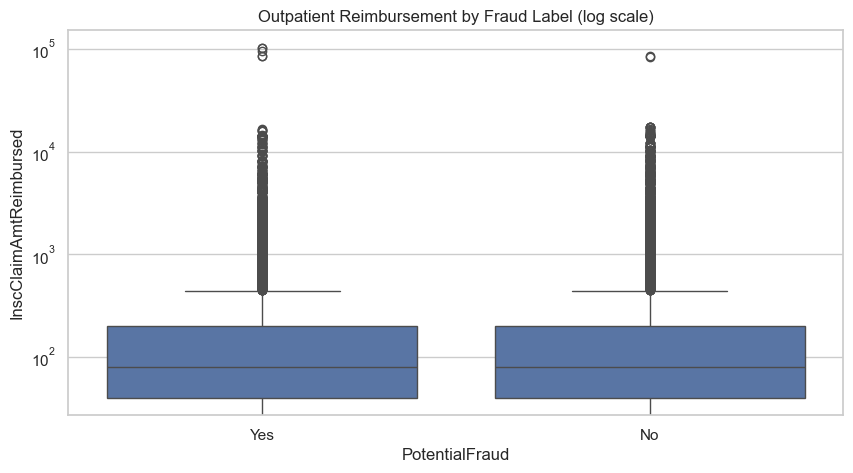

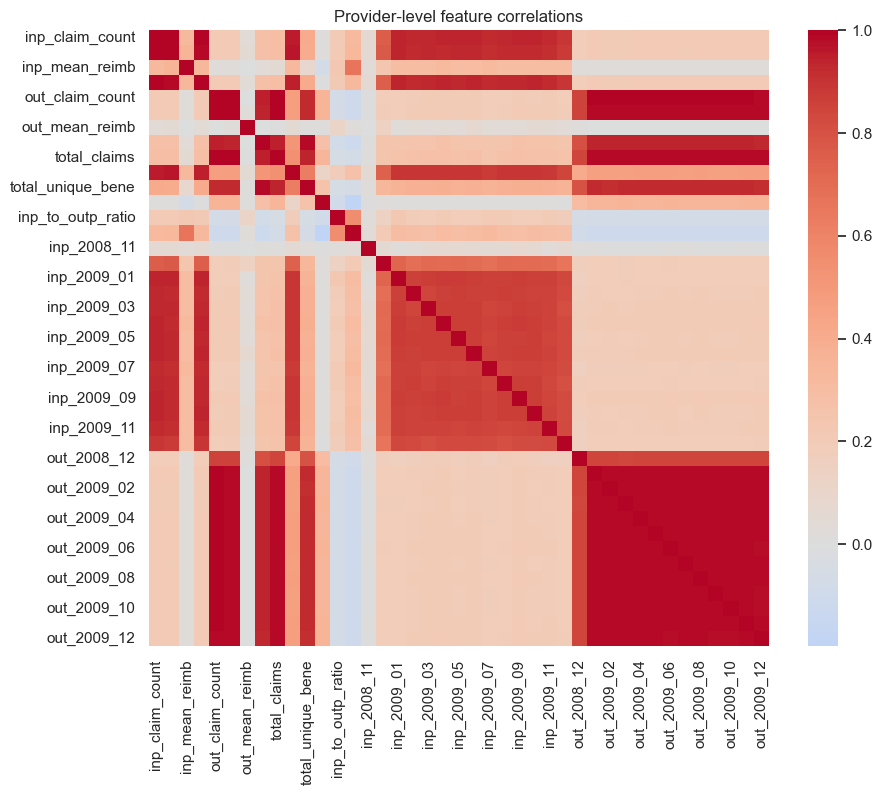

Saved processed_train_data.csv


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

# Files (adjust names if necessary)
bene_file = 'Train_Beneficiarydata.csv'
inp_file  = 'Train_Inpatientdata.csv'
out_file  = 'Train_Outpatientdata.csv'
labels_file = 'Train_labels.csv'

# Load (will raise informative error if missing)
bene_df = pd.read_csv(bene_file)
inp_df  = pd.read_csv(inp_file)
out_df  = pd.read_csv(out_file)
prov_df = pd.read_csv(labels_file)

print('Loaded shapes:')
print('bene:', bene_df.shape)
print('inp :', inp_df.shape)
print('out :', out_df.shape)
print('prov:', prov_df.shape)

# Relationship validation
print('Providers (labels):', prov_df['Provider'].nunique())
print('Beneficiaries:', bene_df['BeneID'].nunique())
print('Inpatient claims:', inp_df['ClaimID'].nunique())
print('Outpatient claims:', out_df['ClaimID'].nunique())

assert prov_df['Provider'].is_unique, 'Provider not unique in labels'
assert bene_df['BeneID'].is_unique, 'BeneID not unique in beneficiary'

# Missing value profiling
def missing_report(df, name, top_n=10):
    miss = df.isna().mean().sort_values(ascending=False)
    display = (miss*100).head(top_n).round(2).astype(str) + '%'
    print(f"\nMissing in {name}:\n", display)

missing_report(bene_df, 'Beneficiary')
missing_report(inp_df, 'Inpatient')
missing_report(out_df, 'Outpatient')

# Date parsing and basic sanity checks
date_cols = ['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt','DOB','DOD']
for df,name in [(inp_df,'Inpatient'),(out_df,'Outpatient'),(bene_df,'Beneficiary')]:
    for c in date_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')

# Check for start> end
for name,df in [('Inpatient',inp_df),('Outpatient',out_df)]:
    if 'ClaimStartDt' in df.columns and 'ClaimEndDt' in df.columns:
        bad = df[df['ClaimStartDt']>df['ClaimEndDt']]
        print(f"{name} bad date rows: ", len(bad))

# Claims after death (if DOD present)
if 'DOD' in bene_df.columns:
    temp = inp_df.merge(bene_df[['BeneID','DOD']], on='BeneID', how='left')
    print('Inpatient claims after death:', ((temp['DOD'].notna()) & (temp['ClaimStartDt']>temp['DOD'])).sum())

# Map labels to claims
fraud_map = prov_df.set_index('Provider')['PotentialFraud']
inp_df['PotentialFraud'] = inp_df['Provider'].map(fraud_map)
out_df['PotentialFraud'] = out_df['Provider'].map(fraud_map)

inp_df = inp_df.dropna(subset=['PotentialFraud'])
out_df = out_df.dropna(subset=['PotentialFraud'])

print('Fraud rate in providers (labels):', (prov_df['PotentialFraud']=='Yes').mean())
print('Fraud rate in inpatient claims:', (inp_df['PotentialFraud']=='Yes').mean())
print('Fraud rate in outpatient claims:', (out_df['PotentialFraud']=='Yes').mean())

# Visuals: distribution & boxplots
plt.figure()
sns.histplot(np.log1p(inp_df['InscClaimAmtReimbursed'].fillna(0)), bins=50)
plt.title('Log Inpatient Reimbursement Distribution')
plt.show()

plt.figure()
sns.boxplot(data=inp_df, x='PotentialFraud', y='InscClaimAmtReimbursed')
plt.yscale('log')
plt.title('Inpatient Reimbursement by Fraud Label (log scale)')
plt.show()

plt.figure()
sns.boxplot(data=out_df, x='PotentialFraud', y='InscClaimAmtReimbursed')
plt.yscale('log')
plt.title('Outpatient Reimbursement by Fraud Label (log scale)')
plt.show()

# Aggregate inpatient and outpatient to provider
agg_inp = inp_df.groupby('Provider').agg(
    inp_claim_count=('ClaimID','nunique'),
    inp_total_reimb=('InscClaimAmtReimbursed','sum'),
    inp_mean_reimb=('InscClaimAmtReimbursed','mean'),
    inp_unique_bene=('BeneID','nunique')
)

agg_out = out_df.groupby('Provider').agg(
    out_claim_count=('ClaimID','nunique'),
    out_total_reimb=('InscClaimAmtReimbursed','sum'),
    out_mean_reimb=('InscClaimAmtReimbursed','mean'),
    out_unique_bene=('BeneID','nunique')
)

# Merge with labels
provider_df = prov_df.set_index('Provider').join(agg_inp).join(agg_out)
provider_df = provider_df.reset_index()

# Create combined features
provider_df['total_claims'] = provider_df['inp_claim_count'].fillna(0) + provider_df['out_claim_count'].fillna(0)
provider_df['total_reimb'] = provider_df['inp_total_reimb'].fillna(0) + provider_df['out_total_reimb'].fillna(0)
provider_df['total_unique_bene'] = provider_df['inp_unique_bene'].fillna(0) + provider_df['out_unique_bene'].fillna(0)
provider_df['claims_per_patient'] = provider_df['total_claims'] / (provider_df['total_unique_bene'] + 1)
provider_df['inp_to_outp_ratio'] = provider_df['inp_claim_count'].fillna(0) / (provider_df['out_claim_count'].fillna(0) + 1)
provider_df['avg_claim_cost'] = provider_df['total_reimb'] / (provider_df['total_claims'] + 1)

# Temporal features (monthly claim counts)
if 'ClaimStartDt' in inp_df.columns:
    inp_df['ClaimMonth'] = inp_df['ClaimStartDt'].dt.to_period('M').dt.to_timestamp()
    out_df['ClaimMonth'] = out_df['ClaimStartDt'].dt.to_period('M').dt.to_timestamp()
    
    monthly_inp = inp_df.groupby(['Provider','ClaimMonth']).size().unstack(fill_value=0)
    monthly_out = out_df.groupby(['Provider','ClaimMonth']).size().unstack(fill_value=0)
    
    # prefix columns to avoid collisions
    monthly_inp.columns = [f'inp_{c.strftime("%Y_%m")}' for c in monthly_inp.columns]
    monthly_out.columns = [f'out_{c.strftime("%Y_%m")}' for c in monthly_out.columns]
    
    provider_df = provider_df.merge(monthly_inp.reset_index(), on='Provider', how='left').merge(monthly_out.reset_index(), on='Provider', how='left').fillna(0)

# Geographic features (state-level)
if 'State' in bene_df.columns:
    bene_small = bene_df[['BeneID','State']]
    inp_geo = inp_df[['BeneID','Provider']].merge(bene_small, on='BeneID', how='left')
    provider_state = (
    inp_geo[['Provider', 'State']]
    .dropna(subset=['State'])
    .drop_duplicates()
    .groupby('Provider')['State']
    .apply(lambda x: ', '.join(sorted(x.astype(str).unique())[:3]))
)


    provider_df = provider_df.merge(provider_state.reset_index().rename(columns={'State':'top_states'}), on='Provider', how='left')

# Correlation heatmap and save processed data
num_cols = provider_df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(provider_df[num_cols].corr(), cmap='coolwarm', center=0)
plt.title('Provider-level feature correlations')
plt.show()

# Save processed data for modeling
provider_df.to_csv('processed_train_data.csv', index=False)
print('Saved processed_train_data.csv')
